In [269]:
import numpy as np
import matplotlib.pyplot as plt

In [263]:
T = 2
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = [1-alpha,alpha,0.5]
Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)



In [264]:
# Since numpy doesn't have built in support for categorical distribution
def categorical(distribution: np.array):
    # returns the result of a single sample drawn from a binomial distribution <distribution> 
    sample = np.random.multinomial(1,distribution)
    res = np.where(sample)[0][0]
    return res

In [265]:
# Simulate

C = np.zeros(T,dtype='int32')
Z = np.zeros((T,n),dtype='int32')
X = np.zeros((T,n),dtype='int32')
C[0] = 2
for t in range(T):
    if t == 0:
        pass
    else:
        C[t] = categorical(Gamma[C[t-1]])
    Z[t] = np.random.binomial(1,cpd_z[C[t]],size=n)
    for i in range(n):
        X[t][i] = np.random.poisson(Lambda[Z[t][i]])

    


Text(0.5, 0, 't')

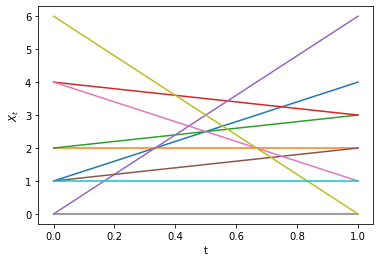

In [266]:
for i in range(n):
    plt.plot(X[0:,i])
plt.ylabel(r'$X_{t}$')
plt.xlabel('t')


In [267]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X,C)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 2

In [251]:
C

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [253]:
coin = lambda p, size=None: np.random.binomial(1, p, size=size)
poisson = lambda p, x : np.exp(-p)*(p**x)/np.math.factorial(x)

px = np.array([[poisson(p_,x_) for p_ in (1,5)] for x_ in range(20)])
px


array([[3.67879441e-01, 6.73794700e-03],
       [3.67879441e-01, 3.36897350e-02],
       [1.83939721e-01, 8.42243375e-02],
       [6.13132402e-02, 1.40373896e-01],
       [1.53283100e-02, 1.75467370e-01],
       [3.06566201e-03, 1.75467370e-01],
       [5.10943668e-04, 1.46222808e-01],
       [7.29919526e-05, 1.04444863e-01],
       [9.12399408e-06, 6.52780393e-02],
       [1.01377712e-06, 3.62655774e-02],
       [1.01377712e-07, 1.81327887e-02],
       [9.21615563e-09, 8.24217669e-03],
       [7.68012969e-10, 3.43424029e-03],
       [5.90779207e-11, 1.32086165e-03],
       [4.21985148e-12, 4.71736303e-04],
       [2.81323432e-13, 1.57245434e-04],
       [1.75827145e-14, 4.91391982e-05],
       [1.03427732e-15, 1.44527054e-05],
       [5.74598513e-17, 4.01464038e-06],
       [3.02420270e-18, 1.05648431e-06]])

In [254]:
c = np.zeros(T)

var = cpd_z @ px[X[0][0]]
sigma = [0,0,1] * var
c[0] = sigma.sum()
sigma /= c[0]
sigma

# rækkefølge er underordnet, da Gamma er symmetrisk
tau = sigma @ Gamma

for t in range(1,T):
    tau = Gamma @ sigma
    # cpd_z @ px[X[t][0]] is P(Z|C)
    sigma = tau * (cpd_z @ px[X[t][0]])
    # normalizing is done by L1-norm
    c[t] = sigma.sum()
    sigma /= c[t]


In [255]:
%%latex
Factorizing a single time-slice of the network yields
$$P(C)^n\sum_Z P(Z|C) \prod_{x_i} P(x_i | Z)$$

<IPython.core.display.Latex object>

In [261]:
c = np.zeros(T)

sigma = np.array([0,0,1])
sigmas = np.zeros((T,3))

for t in range(1,T):
    # matrix multiplication counts as elementwise multiplication and marginalization
    tau = Gamma @ sigma
    # calculate phi's
    phi = 1
    for i in range(n):
        phi *= cpd_z @ px[X[t][i]]
    
    sigma = tau * phi
    c[t] = sigma.sum()
    sigma /= c[t]
    sigmas[t] = sigma



IndexError: index 2 is out of bounds for axis 0 with size 2

In [257]:
np.vstack(list(zip(sigmas,C)))

array([[array([0., 0., 0.]), 2],
       [array([0.21068937, 0.0216399 , 0.76767073]), 2],
       [array([0.14032077, 0.04388164, 0.81579759]), 2],
       [array([0.03399692, 0.28313657, 0.68286651]), 2],
       [array([0.15459351, 0.1197273 , 0.72567919]), 2],
       [array([0.00935233, 0.47748797, 0.5131597 ]), 0],
       [array([0.0092705 , 0.68720643, 0.30352307]), 0],
       [array([0.01044889, 0.70879221, 0.2807589 ]), 0],
       [array([0.00126566, 0.86777849, 0.13095585]), 0],
       [array([0.00174877, 0.89796845, 0.10028278]), 0],
       [array([5.30789599e-04, 9.29767951e-01, 6.97012595e-02]), 0],
       [array([0.00233698, 0.90306595, 0.09459707]), 0],
       [array([3.40979104e-04, 9.35556797e-01, 6.41022244e-02]), 0],
       [array([0.10375841, 0.19267432, 0.70356727]), 2],
       [array([0.46829492, 0.00861981, 0.52308527]), 1],
       [array([0.34656706, 0.04304364, 0.6103893 ]), 2],
       [array([0.21042754, 0.05593544, 0.73363702]), 2],
       [array([0.47351042, 0.02

In [258]:
C

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [268]:
X

array([[1, 2, 2, 4, 0, 1, 4, 0, 6, 1],
       [4, 2, 3, 3, 6, 2, 1, 0, 0, 1]])